# Step 1: Setup dan Pencarian Lokasi Data (Fondasi)

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.9 MB/s eta 0:00:00


In [2]:
#Setup library awal
import os
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import pandas as pd
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Pencarian Lokasi Data
print("Daftar folder di dataset:")

base_path = '/kaggle/input/tomato-leaf-diseases-dataset-for-object-detection/Tomato leaf diseases dataset for Object Detection'

if os.path.exists(base_path):
    for item in os.listdir(base_path):
        print(f" - {item}")
else:
    print("Cek dari root /kaggle/input")
    for root, dirs, files in os.walk('/kaggle/input'):
        if root.cunt(os.sep) < 4:
            print(f" {root}")

Daftar folder di dataset:
 - README_es.txt
 - README_en.txt
 - Dataset without augmentation
 - Dataset with augmentation


In [4]:
#Lock file augmentasi
dataset_root = '/kaggle/input/tomato-leaf-diseases-dataset-for-object-detection/Tomato leaf diseases dataset for Object Detection/Dataset with augmentation'

if os.path.exists(dataset_root):
    print(f"Kita akan memakai dataset di: {dataset_root}")

    isi_folder = os.listdir(dataset_root)
    if 'train' in isi_folder and 'valid' in isi_folder:
        print("Status: folder 'train' dan 'valid' ditemukan!")

        #Definisi nama kelas
        class_names = [
            'Early Blight',          # ID 0
            'Healthy',               # ID 1
            'Late Blight',           # ID 2
            'Leaf Miner',            # ID 3
            'Leaf Mold',             # ID 4
            'Mosaic Virus',          # ID 5
            'Septoria',              # ID 6
            'Spider Mites',          # ID 7
            'Yellow Leaf Curl Virus' # ID 8
        ]
    else:
        print("PERINGATAN: Di dalam folder ini tidak ditemukan subfolder 'train' atau 'valid'.")
        print(f"Isi folder yang kamu pilih: {isi_folder}")
        print("Coba cek lagi path-nya, mungkin kurang masuk ke dalam satu folder lagi?")
else:
   print(f"ERROR: Path '{dataset_root}' tidak ditemukan.")

Kita akan memakai dataset di: /kaggle/input/tomato-leaf-diseases-dataset-for-object-detection/Tomato leaf diseases dataset for Object Detection/Dataset with augmentation
Status: folder 'train' dan 'valid' ditemukan!


# Step 2: Exploratory Data Analysis

## a. Pengecekan Persebaran Data

Sedang menghitung label....


/tmp/ipykernel_23/2023498999.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Jumlah', y='Penyakit', data=df, palette='viridis')


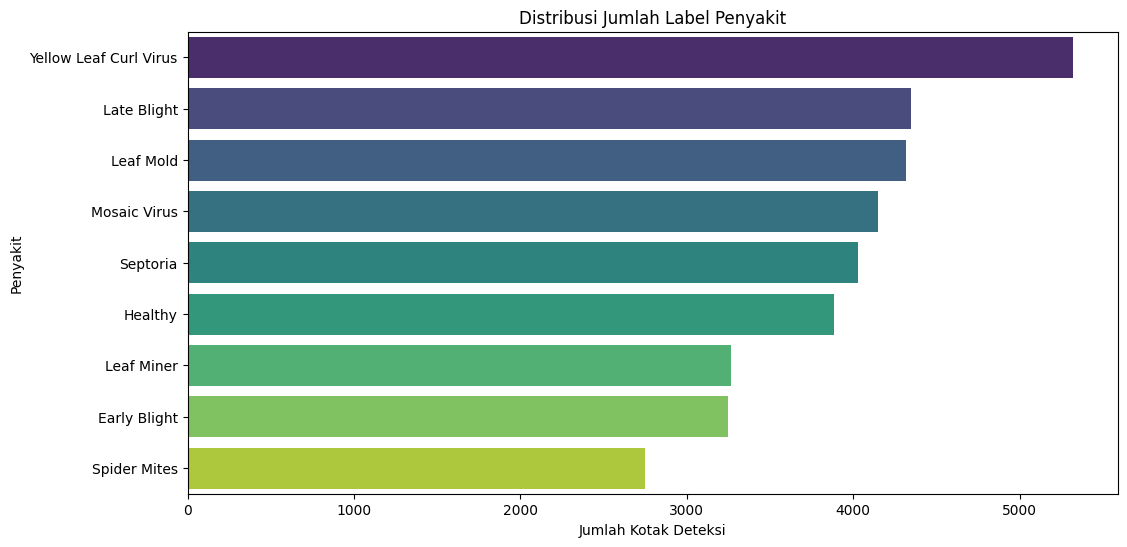

Detail Jumlah:
                  Penyakit  Jumlah
8  Yellow Leaf Curl Virus    5322
2             Late Blight    4349
4               Leaf Mold    4320
5            Mosaic Virus    4146
6                Septoria    4028
1                 Healthy    3885
3              Leaf Miner    3266
0            Early Blight    3245
7            Spider Mites    2747


In [5]:
train_label_dir = os.path.join(dataset_root, 'train/labels')
label_files = glob.glob(os.path.join(train_label_dir, '*.txt'))

class_counts = {name: 0 for name in class_names}

print("Sedang menghitung label....")

for file in label_files:
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Format YOLO: class_id x y w h
            parts = line.strip().split()
            if len(parts) >= 1:
                class_id = int(parts[0])
                if class_id < len(class_names):
                    class_name = class_names[class_id]
                    class_counts[class_name] += 1

#Dataframe untuk Plotting
df = pd.DataFrame(list(class_counts.items()), columns=['Penyakit', 'Jumlah'])
df = df.sort_values(by='Jumlah', ascending=False)

#Tampilan grafaik
plt.figure(figsize=(12, 6))
sns.barplot(x='Jumlah', y='Penyakit', data=df, palette='viridis')
plt.title("Distribusi Jumlah Label Penyakit")
plt.xlabel("Jumlah Kotak Deteksi")
plt.show()

print("Detail Jumlah:\n", df)

## b. Ground Truth

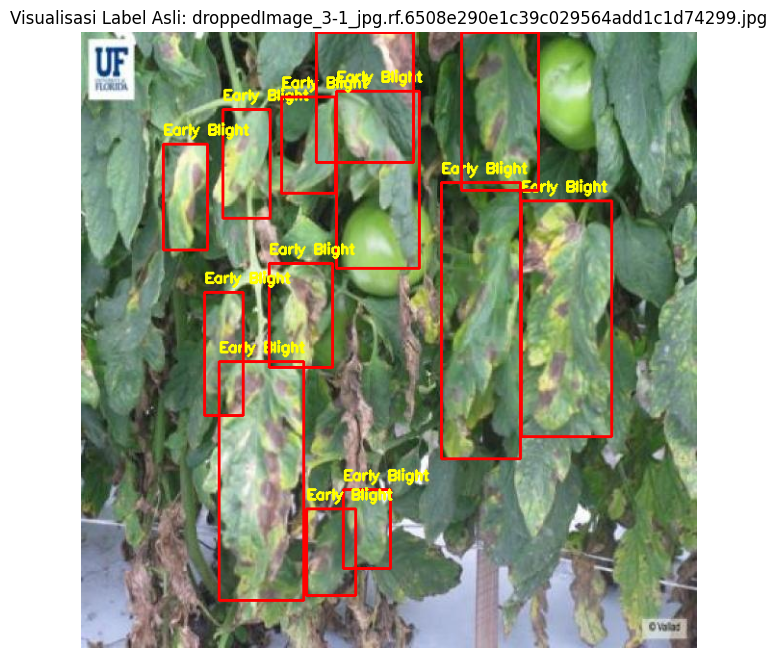

In [6]:
# Ambil 1 gambar acak dan label pasangannya
train_img_dir = os.path.join(dataset_root, 'train/images')
random_img_file = random.choice(os.listdir(train_img_dir))
img_path = os.path.join(train_img_dir, random_img_file)
label_path = os.path.join(train_label_dir, random_img_file.replace('.jpg', '.txt').replace('.JPG', '.txt'))

# Baca Gambar
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# Baca Label dan Gambar Kotak
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            # Konversi koordinat YOLO (0-1) ke Pixel
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            
            # Gambar Kotak & Teks
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2) # Kotak Merah
            label_text = class_names[class_id]
            cv2.putText(image, label_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Visualisasi Label Asli: {random_img_file}")
    plt.axis('off')
    plt.show()
else:
    print("Label file tidak ditemukan untuk gambar ini.")

## c. Feature Map

In [7]:
# Kita pakai model pre-trained (yolov8n.pt) untuk bedah fitur
model_vis = YOLO('yolov8n.pt') 

# Jalankan prediksi dengan visualize=True
# Kita pakai gambar sampel yang sama dengan di atas
results = model_vis.predict(img_path, visualize=True, save=True, project='bedah_tomat', name='layer_vis')

# Tampilkan hasil visualisasi layer (biasanya stage0, stage1, dst)
vis_dir = '/kaggle/working/bedah_tomat/layer_vis'
feature_maps = sorted(glob.glob(os.path.join(vis_dir, 'stage*_features.png')))

if feature_maps:
    plt.figure(figsize=(15, 5))
    for i, fmap in enumerate(feature_maps[:4]): # Ambil 4 layer awal
        img_vis = cv2.imread(fmap)
        plt.subplot(1, 4, i+1)
        plt.imshow(img_vis)
        plt.title(f"Layer Stage {i}")
        plt.axis('off')
    plt.suptitle("Bagaimana YOLO Melihat Fitur Daun (Feature Maps)")
    plt.show()


Saving /kaggle/working/runs/detect/bedah_tomat/layer_vis/droppedImage_3-1_jpg.rf.6508e290e1c39c029564add1c1d74299/stage0_Conv_features.png... (16/16)
Saving /kaggle/working/runs/detect/bedah_tomat/layer_vis/droppedImage_3-1_jpg.rf.6508e290e1c39c029564add1c1d74299/stage1_Conv_features.png... (32/32)
Saving /kaggle/working/runs/detect/bedah_tomat/layer_vis/droppedImage_3-1_jpg.rf.6508e290e1c39c029564add1c1d74299/stage2_C2f_features.png... (32/32)
Saving /kaggle/working/runs/detect/bedah_tomat/layer_vis/droppedImage_3-1_jpg.rf.6508e290e1c39c029564add1c1d74299/stage3_Conv_features.png... (32/64)
Saving /kaggle/working/runs/detect/bedah_tomat/layer_vis/droppedImage_3-1_jpg.rf.6508e290e1c39c029564add1c1d74299/stage4_C2f_features.png... (32/64)
Saving /kaggle/working/runs/detect/bedah_tomat/layer_vis/droppedImage_3-1_jpg.rf.6508e290e1c39c029564add1c1d74299/stage5_Conv_features.png... (32/128)
Saving /kaggle/working/runs/detect/bedah_tomat/layer_vis/droppedImage_3-1_jpg.rf.6508e290e1c39c02956

# Step 3: Training Data (YOLOV8 NANO)

In [8]:
dataset_root = '/kaggle/input/tomato-leaf-diseases-dataset-for-object-detection/Tomato leaf diseases dataset for Object Detection/Dataset with augmentation' 

# Cek dulu biar gak zonk
if not os.path.exists(dataset_root):
    raise ValueError(f"Path dataset tidak ditemukan: {dataset_root}. Cek lagi path-nya!")

config_content = {
    'path': dataset_root,       # Path utama dataset (Absolut)
    'train': 'train/images',    # Lokasi gambar train (relatif terhadap path utama)
    'val': 'valid/images',      # Lokasi gambar validasi
    
    # Daftar 9 Kelas (Urutan FIX)
    'names': {
        0: 'Early Blight',
        1: 'Healthy',
        2: 'Late Blight',
        3: 'Leaf Miner',
        4: 'Leaf Mold',
        5: 'Mosaic Virus',
        6: 'Septoria',
        7: 'Spider Mites',
        8: 'Yellow Leaf Curl Virus'
    }
}

# Simpan file ini di folder kerja (working directory)
yaml_path = '/kaggle/working/data.yaml'

with open(yaml_path, 'w') as f:
    yaml.dump(config_content, f)

print(f"File konfigurasi baru berhasil dibuat di: {yaml_path}")

# Load model Nano (Kecil tapi cabe rawit)
model = YOLO('yolov8n.pt') 

print("MEMULAI TRAINING 50 EPOCHS...")

results = model.train(
    data='data.yaml',     # File config yang tadi kita buat
    epochs=50,            # <-- UPDATE: Jadi 50 biar makin pinter
    patience=10,          # Tambahan: Kalau 10x putaran gak ada kemajuan, stop aja (biar hemat waktu)
    imgsz=640,            # Resolusi standar deteksi
    batch=16,             # Aman buat GPU P100
    project='Mini_Poject_KST',
    name='Tomat_Deteksi_50e_Final', # Ganti nama biar tau ini yang 50 epoch
    save=True,            # Pastikan simpan model terbaik
    cache=False           # Biar RAM gak meledak
)

File konfigurasi baru berhasil dibuat di: /kaggle/working/data.yaml
MEMULAI TRAINING 50 EPOCHS...
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=Tomat_Deteksi_50e_Final, 

In [9]:
import os
import glob
from ultralytics import YOLO
from IPython.display import FileLink

# --- ISI MANUAL DISINI ---
video_path = '/kaggle/input/test-video-youtube/test_video_youtube.mp4' 
# -------------------------

print(f"📂 Menggunakan video dari: {video_path}")

# Load Model
best_model_path = '/kaggle/working/runs/detect/Mini_Poject_KST/Tomat_Deteksi_50e_Final/weights/best.pt'

# Nama folder output yang kita mau
output_project = 'Hasil_Youtube_Final'
output_name = 'predict' 

if os.path.exists(best_model_path):
    model = YOLO(best_model_path)
    
    print("Mulai mendeteksi video... (Log disembunyikan biar gak nge-lag)")
    
    # PREDICT DENGAN MODE HEMAT MEMORI
    results = model.predict(
        source=video_path, 
        save=True, 
        conf=0.4, 
        project=output_project, 
        name=output_name,
        exist_ok=True,  # Timpa folder kalau sudah ada (biar gak bikin Run1, Run2, dst)
        verbose=False,  # PENTING: Matikan log per frame biar gak berat!
        stream=True     # PENTING: Gunakan generator stream biar hemat RAM
    )
    
    # Kita perlu iterate generatornya biar prosesnya jalan (karena stream=True)
    for r in results:
        pass 
    
    print("🏁 Selesai! Mencari file hasil...")
    
    # Cari file hasil di folder yang BENAR
    # Polanya: output_project / output_name / *.avi
    search_pattern = f'/kaggle/working/{output_project}/{output_name}/*.avi'
    found_files = glob.glob(search_pattern)
    
    if found_files:
        print(f"Video Hasil Deteksi Siap Download ({len(found_files)} file):")
        for file in found_files:
            display(FileLink(file))
    else:
        print(f"File hasil tidak ketemu di: {search_pattern}")
        print("Coba cek manual di panel kanan folder 'Hasil_Youtube_Final'")

else:
    print("❌ Model best.pt tidak ditemukan! Cek path-nya lagi.")

📂 Menggunakan video dari: /kaggle/input/test-video-youtube/test_video_youtube.mp4
Mulai mendeteksi video... (Log disembunyikan biar gak nge-lag)
Results saved to /kaggle/working/runs/detect/Hasil_Youtube_Final/predict
🏁 Selesai! Mencari file hasil...
File hasil tidak ketemu di: /kaggle/working/Hasil_Youtube_Final/predict/*.avi
Coba cek manual di panel kanan folder 'Hasil_Youtube_Final'
